In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelBinarizer
#import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# To load Input data

In [2]:
dataset_test = pd.read_csv('tcd-ml-1920-group-income-train.csv')
dataset_pred = pd.read_csv('tcd-ml-1920-group-income-test.csv')
store_data = dataset_pred.filter(['Instance'], axis=1)
dataset_test.columns = dataset_test.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
dataset_pred.columns = dataset_pred.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

dataset_test.rename(columns={'Work_Experience_in_Current_Job_[years]': 'Work_Experience_in_Current_Job'}, inplace=True)
dataset_pred.rename(columns={'Work_Experience_in_Current_Job_[years]': 'Work_Experience_in_Current_Job'}, inplace=True)

/home/james/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/james/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Remove Instance Column

In [3]:
dataset_test = dataset_test.drop('Instance', 1)
dataset_pred = dataset_pred.drop('Instance', 1)
dataset_test.drop(dataset_test.loc[dataset_test['Total_Yearly_Income_[EUR]']==2548791].index, inplace=True)

# Change null to rand value between std dev around mean. Alternate could be panda interpolate


In [4]:
Column_Name_avg = dataset_test['Year_of_Record'].mean()
Column_Name_std = dataset_test['Year_of_Record'].std()
Column_Name_null_count = dataset_test['Year_of_Record'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
dataset_test['Year_of_Record'][np.isnan(dataset_test['Year_of_Record'])] = Column_Name_null_random_list
dataset_test['Year_of_Record'] = dataset_test['Year_of_Record'].astype(int)

Column_Name_avg = dataset_pred['Year_of_Record'].mean()
Column_Name_std = dataset_pred['Year_of_Record'].std()
Column_Name_null_count = dataset_pred['Year_of_Record'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
dataset_pred['Year_of_Record'][np.isnan(dataset_pred['Year_of_Record'])] = Column_Name_null_random_list
dataset_pred['Year_of_Record'] = dataset_pred['Year_of_Record'].astype(int)

/home/james/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/james/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# Filling Gender Nan and other values


In [5]:
dataset_test.Gender = dataset_test.Gender.replace("f", "female")
dataset_test["Gender"].fillna("unknown", inplace = True)
dataset_test.Gender = dataset_test.Gender.replace("0", "unknown")

dataset_pred.Gender = dataset_pred.Gender.replace("f", "female")
dataset_pred["Gender"].fillna("unknown", inplace = True)
dataset_pred.Gender = dataset_pred.Gender.replace("0", "unknown")

# Filling University Degree Nan Values

In [6]:
dataset_test.University_Degree = dataset_test.University_Degree.replace("0", "No")
dataset_test["University_Degree"].fillna("No", inplace = True)

dataset_pred.University_Degree = dataset_pred.University_Degree.replace("0", "No")
dataset_pred["University_Degree"].fillna("No", inplace = True)

# Filling Haircolor Nan Values

In [7]:
dataset_test.Hair_Color = dataset_test.Hair_Color.replace("0", "Unknown")
dataset_test["Hair_Color"].fillna("Unknown", inplace = True)
dataset_test = dataset_test.drop('Hair_Color', 1)

dataset_pred.Hair_Color = dataset_pred.Hair_Color.replace("0", "Unknown")
dataset_pred["Hair_Color"].fillna("Unknown", inplace = True)
dataset_pred = dataset_pred.drop('Hair_Color', 1)

# Filling Profession Nan Values

In [8]:
dataset_test["Profession"].fillna("Unknown", inplace = True)
dataset_pred["Profession"].fillna("Unknown", inplace = True)

# Filling Housing_Situation Corrupt Values

In [9]:
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace(0,'Unknown')
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace('0','Unknown')
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace('nA','Unknown')

dataset_pred["Housing_Situation"] = dataset_pred["Housing_Situation"].replace(0,'Unknown')
dataset_pred["Housing_Situation"] = dataset_pred["Housing_Situation"].replace('0','Unknown')
dataset_pred["Housing_Situation"] = dataset_pred["Housing_Situation"].replace('nA','Unknown')


dataset_test['Satisfation_with_employer'] = dataset_test['Satisfation_with_employer'].fillna(method='ffill')
dataset_pred['Satisfation_with_employer'] = dataset_pred['Satisfation_with_employer'].fillna(method='ffill')

# Convert work Experience in current job to float and replace #NUM! to mean of their Age

In [10]:
dataset_test.Work_Experience_in_Current_Job = dataset_test.Work_Experience_in_Current_Job.replace("#NUM!", None)
dataset_test['Work_Experience_in_Current_Job'] = dataset_test['Work_Experience_in_Current_Job'].astype(float)
dataset_test.value = dataset_test.groupby('Age')['Work_Experience_in_Current_Job'].apply(lambda x: x.fillna(x.median()))
dataset_test.value = dataset_test.Work_Experience_in_Current_Job.fillna(dataset_test.Work_Experience_in_Current_Job.median())

dataset_pred.Work_Experience_in_Current_Job = dataset_pred.Work_Experience_in_Current_Job.replace("#NUM!", None)
dataset_pred['Work_Experience_in_Current_Job'] = dataset_pred['Work_Experience_in_Current_Job'].astype(float)
dataset_pred.value = dataset_pred.groupby('Age')['Work_Experience_in_Current_Job'].apply(lambda x: x.fillna(x.median()))
dataset_pred.value = dataset_pred.Work_Experience_in_Current_Job.fillna(dataset_pred.Work_Experience_in_Current_Job.median())

/home/james/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/home/james/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


# Remove EUR in Yearly_Income to make it numerical value 

In [11]:
dataset_test['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'] = dataset_test['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'].replace('EUR', '', regex=True).astype(float)
dataset_pred['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'] = dataset_pred['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'].replace('EUR', '', regex=True).astype(float)

# Label encoding the categorical columns

In [12]:
for col in dataset_test.dtypes[dataset_test.dtypes == 'object'].index.tolist():
    feat_le = LabelEncoder()
    train_list = dataset_test[col].unique()
    dataset_test.loc[1201,col] = 'other'
    test_list = dataset_pred[col].unique()
    test_replace = list(set(test_list) - set(train_list))
    dataset_pred[col] = dataset_pred[col].replace(test_replace, 'other')
    feat_le.fit(dataset_test[col].unique().astype(str))
    dataset_test[col] = feat_le.transform(dataset_test[col].astype(str))
    dataset_pred[col] = feat_le.transform(dataset_pred[col].astype(str))



### This function takes a string column name and returns a list
### containing indices of dataframe that have outliers in that column
### Refer: https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623


In [13]:
def OutlierByColumn(colname):
    rows = dataset_test.shape[0]
    col_std = np.std(dataset_test[colname])
    col_mean = np.mean(dataset_test[colname])
    anomaly_cut_off = col_std * 3
    lower_limit  = col_mean - anomaly_cut_off 
    upper_limit = col_mean + anomaly_cut_off
    anomalies_indices = []
    for i in range(rows):
        ele = dataset_test[colname][i]
        if ele > upper_limit or ele < lower_limit:
            anomalies_indices.append(i)
    return anomalies_indices

# Running outlier

In [14]:
arr1 = OutlierByColumn('Work_Experience_in_Current_Job')
arr2 = OutlierByColumn('Age')
#arr3 = OutlierByColumn('Body_Height_[cm]')
arr4 = OutlierByColumn('Yearly_Income_in_addition_to_Salary_e.g._Rental_Income')
arr5 = OutlierByColumn('Size_of_City')

In [15]:
#Union of all lists 
union_index = np.union1d(arr1,arr2)
#union_index = np.union1d(union_index,arr3)
union_index = np.union1d(union_index,arr4)
union_index = np.union1d(union_index,arr5)
len(union_index)
dataset_test = dataset_test.drop(union_index)

# View Data

In [20]:
dataset_test.head(5)

,Year_of_Record,Housing_Situation,Crime_Level_in_the_City_of_Employement,Work_Experience_in_Current_Job,Satisfation_with_employer,Gender,Age,Country,Size_of_City,Profession,University_Degree,Wears_Glasses,Body_Height_[cm],Yearly_Income_in_addition_to_Salary_e.g._Rental_Income,Total_Yearly_Income_[EUR]
0,1940,7,33,17.0,3,2,45,1,25179,611,2,1,182,0.0,6182.05
1,1940,7,25,4.9,3,0,17,1,2278204,623,2,0,172,0.0,6819.69
2,1940,7,34,21.0,3,0,48,1,822134,1195,0,0,144,0.0,8663.53
3,1940,7,70,18.0,0,0,42,2,59477,1009,2,1,152,0.0,2400.64
4,1940,7,51,8.0,1,2,15,2,23494,761,1,1,180,0.0,2816.18


In [21]:
y = dataset_test['Total_Yearly_Income_[EUR]'].values
dataset_test.drop('Total_Yearly_Income_[EUR]', axis=1, inplace=True)
X = dataset_test[dataset_test.columns].values

In [22]:
print(y.shape)
print(X.shape)

(997110,)
(997110, 14)


In [23]:
#split 80% of the data to the training set while 20% of the data to test set.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1)

In [24]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(897399, 14) (99711, 14)
(897399,) (99711,)


In [25]:

#dataset_pred.drop('Total_Yearly_Income_[EUR]', axis=1, inplace=True)
#X_test = dataset_pred[dataset_pred.columns].values

# KERAS Model

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dropout

Using TensorFlow backend.


In [38]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)


In [39]:
model = Sequential()
model.add(Dense(14, input_dim=14,kernel_initializer='RandomUniform', activation= "relu"))
model.add(Dropout(0.2))
model.add(Dense(7,kernel_initializer='normal', activation= "relu"))
model.add(Dense(1))

In [40]:
model.compile(loss= "mean_absolute_error" , optimizer=sgd, metrics=["mean_absolute_error"])

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 14)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8         
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________


In [43]:
hist = model.fit(X_train, Y_train,
          batch_size=1024, epochs=30,
          validation_split=0.2)

Train on 717919 samples, validate on 179480 samples
Epoch 1/30
717919/717919 [==============================] - 4s 6us/step - loss: 62907.7786 - mean_absolute_error: 62907.7786 - val_loss: 63064.6327 - val_mean_absolute_error: 63064.6327
Epoch 2/30
717919/717919 [==============================] - 4s 6us/step - loss: 62380.7121 - mean_absolute_error: 62380.7121 - val_loss: 62585.9120 - val_mean_absolute_error: 62585.9120
Epoch 3/30
717919/717919 [==============================] - 4s 6us/step - loss: 61943.3312 - mean_absolute_error: 61943.3312 - val_loss: 62186.4939 - val_mean_absolute_error: 62186.4939
Epoch 4/30
717919/717919 [==============================] - 4s 6us/step - loss: 61575.0259 - mean_absolute_error: 61575.0259 - val_loss: 61846.2615 - val_mean_absolute_error: 61846.2615
Epoch 5/30
717919/717919 [==============================] - 4s 6us/step - loss: 61259.1733 - mean_absolute_error: 61259.1733 - val_loss: 61551.2405 - val_mean_absolute_error: 61551.2405
Epoch 6/30
717919/

In [44]:
model.evaluate(X_test, Y_test)[1]

99711/99711 [==============================] - 5s 47us/step


58820.074504615215

# Visualizing Loss & Accuracy

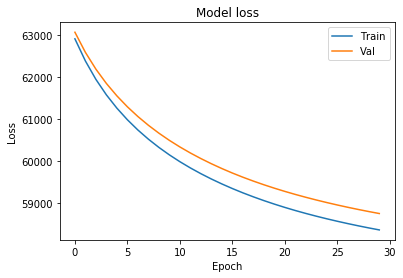

In [45]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Output

In [ ]:
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
store_data['Total Yearly Income [EUR]'] = y_pred
store_data.to_csv('output.csv', sep=',')